<a href="https://colab.research.google.com/github/gopal2812/mlblr/blob/master/LRP_Implementation_checkpoint.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

### Gopal Gupta

This notebook describes the implementation of **Layer-wise Relevance Propogation (LRP)** which is a **gradient based attribution method** for LSTM regression model trained on time-series data along with their issues and limitations. It contains data pre-processing, model summary, LRP implementation. My observations are documented.

In [1]:
!pip install hickle
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sea
from sklearn.preprocessing import MinMaxScaler
%matplotlib inline
from numpy.random import seed
import time
import tensorflow as tf
import pickle
import h5py
import hickle as hkl

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 107.9/107.9 kB 2.4 MB/s eta 0:00:00


In [2]:
from google.colab import files
files.upload()

Saving kaggle.json to kaggle.json


{'kaggle.json': b'{"username":"ergopal","key":"f3de54ddf3bc3b7ba6c2ee01060600eb"}'}

In [3]:
! mkdir ~/.kaggle

! cp kaggle.json ~/.kaggle/
! chmod 600 ~/.kaggle/kaggle.json
! kaggle datasets list
! kaggle datasets download -d vinayak123tyagi/bearing-dataset

ref                                                                 title                                             size  lastUpdated          downloadCount  voteCount  usabilityRating  
------------------------------------------------------------------  -----------------------------------------------  -----  -------------------  -------------  ---------  ---------------  
thedrcat/daigt-v2-train-dataset                                     DAIGT V2 Train Dataset                            29MB  2023-11-16 01:38:36           1826        181  1.0              
thedevastator/books-sales-and-ratings                               Books Sales and Ratings                           53KB  2023-12-06 04:54:33           1783         28  1.0              
muhammadbinimran/housing-price-prediction-data                      Housing Price Prediction Data                    763KB  2023-11-21 17:56:32           8192        146  1.0              
jocelyndumlao/cardiovascular-disease-dataset           

In [4]:
#!unzip /content/bearing-dataset.zip

Streaming output truncated to the last 5000 lines.
  inflating: 3rd_test/4th_test/txt/2004.03.13.14.12.46  
  inflating: 3rd_test/4th_test/txt/2004.03.13.14.22.46  
  inflating: 3rd_test/4th_test/txt/2004.03.13.14.32.46  
  inflating: 3rd_test/4th_test/txt/2004.03.13.14.42.46  
  inflating: 3rd_test/4th_test/txt/2004.03.13.14.52.46  
  inflating: 3rd_test/4th_test/txt/2004.03.13.15.02.46  
  inflating: 3rd_test/4th_test/txt/2004.03.13.15.12.46  
  inflating: 3rd_test/4th_test/txt/2004.03.13.15.22.46  
  inflating: 3rd_test/4th_test/txt/2004.03.13.15.32.46  
  inflating: 3rd_test/4th_test/txt/2004.03.13.15.42.46  
  inflating: 3rd_test/4th_test/txt/2004.03.13.15.52.46  
  inflating: 3rd_test/4th_test/txt/2004.03.13.16.02.46  
  inflating: 3rd_test/4th_test/txt/2004.03.13.16.12.46  
  inflating: 3rd_test/4th_test/txt/2004.03.13.16.22.46  
  inflating: 3rd_test/4th_test/txt/2004.03.13.16.32.46  
  inflating: 3rd_test/4th_test/txt/2004.03.13.16.42.46  
  inflating: 3rd_test/4th_test/txt/20

In [5]:
!ls

 1st_test   3rd_test		  kaggle.json				      sample_data
 2nd_test   bearing-dataset.zip  'Readme Document for IMS Bearing Data.pdf'


In [6]:
!mkdir data; mv bearing-dataset.zip data; cd data/ ; unzip bearing-dataset.zip; pwd

Streaming output truncated to the last 5000 lines.
  inflating: 3rd_test/4th_test/txt/2004.03.13.14.22.46  
  inflating: 3rd_test/4th_test/txt/2004.03.13.14.32.46  
  inflating: 3rd_test/4th_test/txt/2004.03.13.14.42.46  
  inflating: 3rd_test/4th_test/txt/2004.03.13.14.52.46  
  inflating: 3rd_test/4th_test/txt/2004.03.13.15.02.46  
  inflating: 3rd_test/4th_test/txt/2004.03.13.15.12.46  
  inflating: 3rd_test/4th_test/txt/2004.03.13.15.22.46  
  inflating: 3rd_test/4th_test/txt/2004.03.13.15.32.46  
  inflating: 3rd_test/4th_test/txt/2004.03.13.15.42.46  
  inflating: 3rd_test/4th_test/txt/2004.03.13.15.52.46  
  inflating: 3rd_test/4th_test/txt/2004.03.13.16.02.46  
  inflating: 3rd_test/4th_test/txt/2004.03.13.16.12.46  
  inflating: 3rd_test/4th_test/txt/2004.03.13.16.22.46  
  inflating: 3rd_test/4th_test/txt/2004.03.13.16.32.46  
  inflating: 3rd_test/4th_test/txt/2004.03.13.16.42.46  
  inflating: 3rd_test/4th_test/txt/2004.03.13.16.52.46  
  inflating: 3rd_test/4th_test/txt/20

In [7]:
ls /content/data; rm -rf /content/data/bearing-dataset.zip /content/data/*.pdf; ls -l /content/data/1st_test/

 1st_test/   3rd_test/            'Readme Document for IMS Bearing Data.pdf'
 2nd_test/   bearing-dataset.zip
total 84
drwxr-xr-x 2 root root 86016 Dec 14 16:39 1st_test


### Data Loading and Pre-processing

The data is a time-series sensor data obtained from NASA vibrational sensors. The data has 4 bearing sensor data as **features - [Bearing 1, Bearing 2, Bearing 3, Bearing 4]** for a time frame as **982 data instances** in total. It is the same data used for SHAP and LIME. [3]

**Dataset:** <br>
https://www.kaggle.com/vinayak123tyagi/bearing-dataset

In [8]:
dir = "/content/data/2nd_test/2nd_test"
dataset = pd.DataFrame()

for filename in os.listdir(dir):
    data = pd.read_csv(os.path.join(dir, filename), sep='\t')
    dataset_mean_abs = np.array(data.abs().mean())
    dataset_mean_abs = pd.DataFrame(dataset_mean_abs.reshape(1,4))
    dataset_mean_abs.index = [filename]
    dataset = dataset.append(dataset_mean_abs)

dataset.columns = ['Bearing 1', 'Bearing 2', 'Bearing 3', 'Bearing 4']

dataset.index = pd.to_datetime(dataset.index, format='%Y.%m.%d.%H.%M.%S')
dataset = dataset.sort_index()
dataset.to_csv('Bearing_Dataset.csv')
print("Dataset shape:", dataset.shape)
dataset.head(15)

<ipython-input-8-64ddcc4a9cec>:9: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  dataset = dataset.append(dataset_mean_abs)
<ipython-input-8-64ddcc4a9cec>:9: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  dataset = dataset.append(dataset_mean_abs)
<ipython-input-8-64ddcc4a9cec>:9: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  dataset = dataset.append(dataset_mean_abs)
<ipython-input-8-64ddcc4a9cec>:9: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  dataset = dataset.append(dataset_mean_abs)
<ipython-input-8-64ddcc4a9cec>:9: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.c

Dataset shape: (984, 4)


<ipython-input-8-64ddcc4a9cec>:9: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  dataset = dataset.append(dataset_mean_abs)
<ipython-input-8-64ddcc4a9cec>:9: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  dataset = dataset.append(dataset_mean_abs)
<ipython-input-8-64ddcc4a9cec>:9: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  dataset = dataset.append(dataset_mean_abs)
<ipython-input-8-64ddcc4a9cec>:9: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  dataset = dataset.append(dataset_mean_abs)
<ipython-input-8-64ddcc4a9cec>:9: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.c

,Bearing 1,Bearing 2,Bearing 3,Bearing 4
2004-02-12 10:32:39,0.058333,0.071832,0.083242,0.043067
2004-02-12 10:42:39,0.058995,0.074006,0.084435,0.044541
2004-02-12 10:52:39,0.060236,0.074227,0.083926,0.044443
2004-02-12 11:02:39,0.061455,0.073844,0.084457,0.045081
2004-02-12 11:12:39,0.061361,0.075609,0.082837,0.045118
2004-02-12 11:22:39,0.061665,0.073279,0.084879,0.044172
2004-02-12 11:32:39,0.061944,0.074593,0.082626,0.044659
2004-02-12 11:42:39,0.061231,0.074172,0.082022,0.043840
2004-02-12 11:52:39,0.062280,0.075808,0.084372,0.044272
2004-02-12 12:02:39,0.059890,0.075115,0.084506,0.043974


In [9]:
dataset.tail(15)

,Bearing 1,Bearing 2,Bearing 3,Bearing 4
2004-02-19 04:02:39,0.255120,0.118554,0.125340,0.095049
2004-02-19 04:12:39,0.269339,0.149217,0.146117,0.106210
2004-02-19 04:22:39,0.294231,0.152531,0.147832,0.109945
2004-02-19 04:32:39,0.299842,0.128478,0.122274,0.098602
2004-02-19 04:42:39,0.248545,0.107334,0.095037,0.090741
2004-02-19 04:52:39,0.329182,0.152795,0.134077,0.102279
2004-02-19 05:02:39,0.416709,0.149921,0.142587,0.095359
2004-02-19 05:12:39,0.351952,0.132498,0.127528,0.111187
2004-02-19 05:22:39,0.338265,0.136772,0.118172,0.116861
2004-02-19 05:32:39,0.301344,0.140436,0.111463,0.114495


In [10]:
#train-Test Split
train_data = dataset['2004-02-12 10:52:39': '2004-02-16 00:32:39']
test_data = dataset['2004-02-16 00:32:39':'2004-02-19 06:22:39']


from sklearn.preprocessing import MinMaxScaler
mean = dataset[['Bearing 1', 'Bearing 2', 'Bearing 3', 'Bearing 4']].mean(axis=1).astype(float)
y = np.array(mean['2004-02-12 10:52:39': '2004-02-16 00:32:39'])

#Data Normalization
scaler = MinMaxScaler()
X_train_transformed = scaler.fit_transform(train_data)
X_test_transformed = scaler.transform(test_data)
y_train_transformed = scaler.fit_transform(y.reshape(-1,1))


#Transforming data into sequences as 3D input.
X_train = X_train_transformed.reshape(X_train_transformed.shape[0], 1, X_train_transformed.shape[1])
print("Training data shape:", X_train.shape)
X_test = X_test_transformed.reshape(X_test_transformed.shape[0], 1, X_test_transformed.shape[1])
print("Test data shape:", X_test.shape)

Training data shape: (515, 1, 4)
Test data shape: (468, 1, 4)


### Simple/Vanilla Bi-Directional LSTM

1. Bi-directional LSTM train two LSTMs on the input sequence in both the directions (i.e.) It reads the input sequence in normal order and also in reverse order. <br>
2. LRP implementation currently supports only bi-directional LSTM, thus bi-directional LSTM layer followed by a dense layer is used to create a model.

In [12]:
from google.colab import files
files.upload()

Saving bidi_model.h5 to bidi_model.h5


{'bidi_model.h5': b'\x89HDF\r\n\x1a\n\x00\x00\x00\x00\x00\x08\x08\x00\x04\x00\x10\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\xff\xff\xff\xff\xff\xff\xff\xff`\xa3\x00\x00\x00\x00\x00\x00\xff\xff\xff\xff\xff\xff\xff\xff\x00\x00\x00\x00\x00\x00\x00\x00`\x00\x00\x00\x00\x00\x00\x00\x01\x00\x00\x00\x00\x00\x00\x00\x88\x00\x00\x00\x00\x00\x00\x00\xa8\x02\x00\x00\x00\x00\x00\x00\x01\x00\x07\x00\x01\x00\x00\x00\x18\x00\x00\x00\x00\x00\x00\x00\x10\x00\x10\x00\x00\x00\x00\x00 \x03\x00\x00\x00\x00\x00\x00h\x01\x00\x00\x00\x00\x00\x00TREE\x00\x00\x01\x00\xff\xff\xff\xff\xff\xff\xff\xff\xff\xff\xff\xff\xff\xff\xff\xff\x00\x00\x00\x00\x00\x00\x00\x00\x00\x18\x00\x00\x00\x00\x00\x00\x18\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x0

In [13]:
bidi_lstm_model = tf.keras.models.load_model('bidi_model.h5')
bidi_lstm_model.summary()

def weight_params(model):
    weights = model.get_weights()
    print("Length of Weight matrix:",len(weights))
    for i in range(len(weights)):
        print(weights[i].shape)
    return weights

Model: "model_3"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_5 (InputLayer)        [(None, 1, 4)]            0         
                                                                 
 bidirectional_3 (Bidirecti  (None, 1, 8)              288       
 onal)                                                           
                                                                 
 flatten_3 (Flatten)         (None, 8)                 0         
                                                                 
 dense_3 (Dense)             (None, 4)                 36        
                                                                 
Total params: 324 (1.27 KB)
Trainable params: 324 (1.27 KB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________


### LRP Implementation [1]

1. LRP is a gradient based attribution method that assigns a relevance score (or) value to each input feature of the neural network. It highlights which input features is used to support the model prediction by propagating from the model prediction backward to the input using set of propogation rules. <br>
2. LRP implementation is done using [1].
3. The same [1] implementation is tweaked in order to apply it for LSTM regression models trained on time series data for anomaly detection.
4. LRP calculates relevance scores for every input features that makes a prediction. For that, **weight matrix** is used.
5. Weight matrix is obtained from keras model as below. It is a list of numpy arrays corresponding to the parameters of the network.
6. The model weight parameters are used in the LRP implementation.
7. Weight matrix includes two matrices **W_x, W_h** and **bias b**. Thus, for one LSTM layer the weight matrix generate 3 values (W_x, W_h, b) and as our model is bi-directional, it is doubled with weights in backward direction => $3*2 = 6$. [1]
8. The shapes of W_x and W_h are (Input dimension, 4 * number of hidden units) and (number of hidden units, 4 * number of LSTM units) respectively.  Thus the shape of W_x is $(4,16)$ and W_h is $(4,16)$ for our model.
9. W_x, W_h corresponds to the **LSTM gates (Input Gate, Forget Gate, Cell Gate, Output Gate)** [1] [2].
10. Dense layer also produces weight matrix and bias. Thus the total weight matrix of bi-directional model = **8 (3+3+2)**.

**Note:** Input and Flatten layer doesn't update or calculate any weights. Thus, they are empty.

In [14]:
weights_bidi_lstm = weight_params(bidi_lstm_model)

Length of Weight matrix: 8
(4, 16)
(4, 16)
(16,)
(4, 16)
(4, 16)
(16,)
(8, 4)
(4,)


In [17]:
!pip install phased-lstm-keras


In [20]:
!pip install seq2seq-lstm

  error: subprocess-exited-with-error
  
  × python setup.py egg_info did not run successfully.
  │ exit code: 1
  ╰─> See above for output.
  
  note: This error originates from a subprocess, and is likely not a problem with pip.
  Preparing metadata (setup.py) ... error
error: metadata-generation-failed

× Encountered error while generating package metadata.
╰─> See above for output.

note: This is an issue with the package mentioned above, not pip.
hint: See above for details.


In [29]:
import tensorflow as tf
import numpy as np


# currently 1 bi-directional lstm layer followed by a dense layer
class LSTM_network:

    def __init__(self, n_hidden, embedding_dim, n_classes, weights=None, debug=False):
        self.n_hidden = n_hidden
        self.embedding_dim = embedding_dim
        self.n_classes = n_classes
        self.debug = debug

        # model parameters
        if weights is not None:
            self.check_weights(weights)
            self.W_x_fward = tf.constant(weights[0], dtype=tf.float64)
            self.W_h_fward = tf.constant(weights[1], dtype=tf.float64)
            self.b_fward = tf.constant(weights[2], dtype=tf.float64)

            self.W_x_bward = tf.constant(weights[3], dtype=tf.float64)
            self.W_h_bward = tf.constant(weights[4], dtype=tf.float64)
            self.b_bward = tf.constant(weights[5], dtype=tf.float64)

            self.W_dense_fw = tf.constant(weights[6][:self.n_hidden], dtype=tf.float64)
            self.W_dense_bw = tf.constant(weights[6][self.n_hidden:], dtype=tf.float64)
            self.b_dense = tf.constant(weights[7], dtype=tf.float64)
        else:
            self.W_x_fward = tf.constant(np.random.randn(self.embedding_dim, 4 * self.n_hidden))
            self.W_h_fward = tf.constant(np.random.randn(self.n_hidden, 4 * self.n_hidden))
            self.b_fward = tf.constant(np.random.randn(4*self.n_hidden,))

            self.W_x_bward = tf.constant(np.random.randn(self.embedding_dim, 4 * self.n_hidden))
            self.W_h_bward = tf.constant(np.random.randn(self.n_hidden, 4 * self.n_hidden))
            self.b_bward = tf.constant(np.random.randn(4 * self.n_hidden, ))

            self.W_dense_fw = tf.constant(np.random.randn(n_hidden, n_classes))
            self.W_dense_bw = tf.constant(np.random.randn(n_hidden, n_classes))
            self.b_dense = tf.constant(np.random.randn(n_classes))

        # prediction of the net
        self.y_hat = tf.Variable(0., shape=tf.TensorShape(None), dtype=tf.float64, name='y_hat')

        # the following order is from keras. You might have to adjust it if you use different frameworks
        self.idx_i = slice(0, self.n_hidden)
        self.idx_f = slice(self.n_hidden, 2 * self.n_hidden)
        self.idx_c = slice(2 * self.n_hidden, 3 * self.n_hidden)
        self.idx_o = slice(3 * self.n_hidden, 4 * self.n_hidden)

    def check_weights(self, weights):
        assert len(weights) == 8
        assert weights[0].shape == weights[3].shape == (self.embedding_dim, 4 * self.n_hidden)
        assert weights[1].shape == weights[4].shape == (self.n_hidden, 4 * self.n_hidden)
        assert weights[2].shape == weights[5].shape == (4 * self.n_hidden, )
        assert weights[6].shape == (2 * self.n_hidden, self.n_classes)
        assert weights[7].shape == (self.n_classes,)

    # x is batch of embedding vectors (batch_size, embedding_dim)
    @tf.function
    def cell_step(self, x, h_old, c_old, W_x, W_h, b):
        # fward pass
        gate_x = tf.matmul(x, W_x)
        gate_h = tf.matmul(h_old, W_h)
        gate_pre = gate_x + gate_h + b
        gate_post = tf.concat([
                            tf.sigmoid(gate_pre[:, self.idx_i]), tf.sigmoid(gate_pre[:, self.idx_f]),
                            tf.tanh(gate_pre[:, self.idx_c]), tf.sigmoid(gate_pre[:, self.idx_o]),
                            ], axis=1)
        c_new = gate_post[:, self.idx_f] * c_old + gate_post[:, self.idx_i] * gate_post[:, self.idx_c]
        h_new = gate_post[:, self.idx_o] * tf.tanh(c_new)
        return gate_pre, gate_post, c_new, h_new

    # x is batch of embedding vectors (batch_size, embedding_dim)
    @tf.function
    def one_step_fward(self, x, h_old_fw, c_old_fw):
        fward = self.cell_step(x, h_old_fw, c_old_fw, self.W_x_fward, self.W_h_fward, self.b_fward)
        return fward

    # x_rev is batch of embedding vectors (batch_size, embedding_dim)
    @tf.function
    def one_step_bward(self, x_rev, h_old_bw, c_old_bw):
        bward = self.cell_step(x_rev, h_old_bw, c_old_bw, self.W_x_bward, self.W_h_bward, self.b_bward)
        return bward

    # input is full batch (batch_size, T, embedding_dim)
    @tf.function(experimental_relax_shapes=True)
    def full_pass(self, x):
        assert len(x.shape) == 3, '3 dimensional input required, got input of len {}'.format(len(x.shape))
        batch_size = x.shape[0]
        # we have to reorder the input since tf.scan scans the input along the first axis
        elems = tf.transpose(x, perm=[1,0,2])
        initializer = (tf.constant(np.zeros((batch_size, 4 * self.n_hidden))),  # gates_pre
                       tf.constant(np.zeros((batch_size, 4 * self.n_hidden))),  # gates_post
                       tf.constant(np.zeros((batch_size, self.n_hidden))),      # c_t
                       tf.constant(np.zeros((batch_size, self.n_hidden))))      # h_t
        fn_fward = lambda a, x: self.one_step_fward(x, a[3], a[2])
        fn_bward = lambda a, x: self.one_step_bward(x, a[3], a[2])
        # outputs contain tesnors with (T, gates_pre, gates_post, c,h)
        o_fward = tf.scan(fn_fward, elems, initializer=initializer)
        o_bward = tf.scan(fn_bward, elems, initializer=initializer, reverse=True)
        # final prediction scores
        y_fward = tf.matmul(o_fward[3][-1], self.W_dense_fw)
        y_bward = tf.matmul(o_bward[3][0], self.W_dense_bw)
        y_hat = y_fward + y_bward + self.b_dense
        self.y_hat.assign(y_hat)
        return y_hat, o_fward, o_bward

    def lrp_linear_layer(self, h_in, w, b, hout, Rout, bias_nb_units, eps, bias_factor=0.0):
        """
        LRP for a linear layer with input dim D and output dim M.
        Args:
        - hin:            forward pass input, of shape (batch_size, D)
        - w:              connection weights, of shape (D, M)
        - b:              biases, of shape (M,)
        - hout:           forward pass output, of shape (batch_size, M) (unequal to np.dot(w.T,hin)+b if more than
                          one incoming layer!)
        - Rout:           relevance at layer output, of shape (batch_size, M)
        - bias_nb_units:  total number of connected lower-layer units (onto which the bias/stabilizer contribution
                          is redistributed for sanity check)
        - eps:            stabilizer (small positive number)
        - bias_factor:    set to 1.0 to check global relevance conservation, otherwise use 0.0 to ignore
                          bias/stabilizer redistribution (recommended)
        Returns:
        - Rin:            relevance at layer input, of shape (batch_size, D)
        """
        bias_factor_t = tf.constant(bias_factor, dtype=tf.float64)
        eps_t = tf.constant(eps, dtype=tf.float64)
        sign_out = tf.cast(tf.where(hout >= 0, 1., -1.), tf.float64)   # shape (batch_size, M)
        numerator_1 = tf.expand_dims(h_in, axis=2) * w
        numerator_2 = bias_factor_t * (tf.expand_dims(b, 0) + eps_t * sign_out) / bias_nb_units
        # use the following term if you want to check relevance property
        #numerator_2 =  (bias_factor_t * tf.expand_dims(b, 0) + eps_t * sign_out) / bias_nb_units
        numerator = numerator_1 + tf.expand_dims(numerator_2, 1)
        denom = hout + (eps*sign_out)
        message = numerator / tf.expand_dims(denom, 1) * tf.expand_dims(Rout, 1)
        R_in = tf.reduce_sum(message, axis=2)
        return R_in

    def lrp(self, x, y=None, eps=1e-3, bias_factor=0.0):
        """
        LRP for a batch of samples x.
        Args:
        - x:              input array. dim = (batch_size, T, embedding_dim)
        - y:              desired output_class to explain. dim = (batch_size,)
        - eps:            eps value for lrp-eps
        - bias_factor:    bias factor for lrp
        Returns:
        - Relevances:     relevances of each input dimension. dim = (batch_size, T, embedding_dim
        """
        assert len(x.shape) == 3, '3 dimensional input required, got input of len {}'.format(len(x.shape))
        lrp_pass = self.lrp_lstm(x,y,eps, bias_factor)
        # add forward and backward relevances of x.
        # Here we have to reverse R_x_fw since the tf.scan() function starts at the last timestep (T-1) and moves to
        # timestep 0. Therefore the last entry of lrp_pass[2] belongs to the first timestep of x. Likewise, the last
        # entry of lrp_pass[5] (R_x_rev) belongs to the last timestep of x and is thus already in the right order.
        Rx_ = tf.reverse(lrp_pass[2], axis=[0]) + lrp_pass[5]
        Rx = tf.transpose(Rx_, perm=(1,0,2))  # put batch dimension to first dim again
        # remaining relevance is sum of last entry of Rh and Rc
        rest = tf.reduce_sum(lrp_pass[0][-1] + lrp_pass[1][-1] + lrp_pass[3][-1] + lrp_pass[4][-1], axis=1)
        return Rx, rest

    @tf.function
    def lrp_lstm(self, x, y=None, eps=1e-3, bias_factor=0.0):
        batch_size = x.shape[0]
        T = x.shape[1]
        x_rev = tf.reverse(x, axis=[1])
        # update inner states
        y_hat, output_fw, output_bw = self.full_pass(x)
        # if classes are given, use them. Else choose prediction of the network
        if y is not None:
            assert y.shape == (batch_size, )
            if not y.dtype is tf.int64:
                y = tf.cast(y, tf.int64)
            R_out_mask = tf.one_hot(y, depth=self.n_classes, dtype=tf.float64)
        else:
            R_out_mask = tf.one_hot(tf.argmax(y_hat, axis=1), depth=self.n_classes, dtype=tf.float64)
        R_T = y_hat * R_out_mask
        gates_pre_fw, gates_post_fw, c_fw, h_fw = output_fw
        gates_pre_bw, gates_post_bw, c_bw, h_bw = output_bw
        # c and h have one timestep more than x (the initial one, we have to add these zeros manually)
        zero_block = tf.constant(np.zeros((1, batch_size, self.n_hidden)))
        c_fw = tf.concat([c_fw, zero_block], axis=0)
        h_fw = tf.concat([h_fw, zero_block], axis=0)
        gates_pre_bw = tf.reverse(gates_pre_bw, [0])
        gates_post_bw = tf.reverse(gates_post_bw, [0])
        c_bw = tf.reverse(c_bw, [0])
        h_bw = tf.reverse(h_bw, [0])
        c_bw = tf.concat([c_bw, zero_block], axis=0)
        h_bw = tf.concat([h_bw, zero_block], axis=0)

        # first calculate relevaces from final linear layer
        Rh_fw_T = self.lrp_linear_layer(h_fw[T - 1], self.W_dense_fw, self.b_dense,
                                       y_hat, R_T, 2*self.n_hidden, eps, bias_factor)
        Rh_bw_T = self.lrp_linear_layer(h_bw[T - 1], self.W_dense_bw, self.b_dense,
                                       y_hat, R_T, 2*self.n_hidden, eps, bias_factor)
        if self.debug:
            tf.print('Dense: Input relevance', tf.reduce_sum(R_T, axis=1))
            tf.print('Dense: Output relevance', tf.reduce_sum(Rh_fw_T+Rh_bw_T, axis=1))
        elems = np.arange(T-1, -1, -1)
        initializer = (
                       Rh_fw_T,                                                                     # R_h_fw
                       Rh_fw_T,                                                                     # R_c_fw
                       tf.constant(np.zeros((batch_size, self.embedding_dim)), name='R_x_fw'),      # R_x_fw
                       Rh_bw_T,                                                                     # R_h_bw
                       Rh_bw_T,                                                                     # R_c_bw
                       tf.constant(np.zeros((batch_size, self.embedding_dim)), name='R_x_bw')       # R_x_bw
                       )
        eye = tf.eye(self.n_hidden, dtype=tf.float64)
        zeros_hidden = tf.constant(np.zeros((self.n_hidden)))

        @tf.function
        def update(input_tuple, t):
            # t starts with T-1 ; the values we want to update are essentially Rh, Rc and Rx
            # input_tuple is (R_h_fw_t+1, R_c_fw_t+1, R_x_fw_t+1, R_h_bw_t+1, R_h_bw_t+1, R_x_bw_t+1)
            #forward
            Rc_fw_t = self.lrp_linear_layer(gates_post_fw[t, :, self.idx_f] * c_fw[t-1, :], eye, zeros_hidden,
                                               c_fw[t, :],  input_tuple[1], 2*self.n_hidden, eps, bias_factor)
            R_g_fw = self.lrp_linear_layer(gates_post_fw[t,:,self.idx_i] * gates_post_fw[t,:,self.idx_c], eye,
                                        zeros_hidden, c_fw[t, :], input_tuple[1], 2*self.n_hidden, eps, bias_factor)
            if self.debug:
                tf.print('Fw1: Input relevance', tf.reduce_sum(input_tuple[1], axis=1))
                tf.print('Fw1: Output relevance', tf.reduce_sum(Rc_fw_t + R_g_fw, axis=1))
            Rx_t = self.lrp_linear_layer(x[:,t], self.W_x_fward[:, self.idx_c], self.b_fward[self.idx_c],
                                         gates_pre_fw[t, :, self.idx_c], R_g_fw, self.n_hidden + self.embedding_dim, eps, bias_factor)
            Rh_fw_t = self.lrp_linear_layer(h_fw[t-1, :], self.W_h_fward[:, self.idx_c], self.b_fward[self.idx_c],
                                            gates_pre_fw[t, :, self.idx_c], R_g_fw, self.n_hidden + self.embedding_dim, eps, bias_factor
                                            )
            if self.debug:
                tf.print('Fw2: Input relevance', tf.reduce_sum(R_g_fw, axis=1))
                tf.print('Fw2: Output relevance', tf.reduce_sum(Rx_t,axis=1)+tf.reduce_sum(Rh_fw_t, axis=1))
            if t != 0:
                Rc_fw_t += Rh_fw_t
            #backward
            Rc_bw_t = self.lrp_linear_layer(gates_post_bw[t, :, self.idx_f] * c_bw[t-1, :], eye, zeros_hidden,
                                            c_bw[t, :], input_tuple[4], 2*self.n_hidden, eps, bias_factor)
            R_g_bw = self.lrp_linear_layer(gates_post_bw[t, :, self.idx_i] * gates_post_bw[t, :, self.idx_c], eye,
                                           zeros_hidden, c_bw[t,:], input_tuple[4], 2*self.n_hidden, eps, bias_factor)
            if self.debug:
                tf.print('Bw1: Input relevance', tf.reduce_sum(input_tuple[4], axis=1))
                tf.print('Bw1: Output relevance', tf.reduce_sum(Rc_bw_t + R_g_bw, axis=1))
            Rx_rev_t = self.lrp_linear_layer(x_rev[:, t], self.W_x_bward[:, self.idx_c], self.b_bward[self.idx_c],
                                            gates_pre_bw[t, :, self.idx_c], R_g_bw, self.n_hidden + self.embedding_dim, eps, bias_factor)
            Rh_bw_t = self.lrp_linear_layer(h_bw[t-1, :], self.W_h_bward[:, self.idx_c], self.b_bward[self.idx_c],
                                            gates_pre_bw[t, :, self.idx_c], R_g_bw, self.n_hidden + self.embedding_dim, eps, bias_factor
                                            )
            if self.debug:
                tf.print('Bw2: Input relevance', tf.reduce_sum(R_g_bw, axis=1))
                tf.print('Bw2: Output relevance', tf.reduce_sum(Rx_rev_t,axis=1)+tf.reduce_sum(Rh_bw_t, axis=1))
            if t != 0:
                Rc_bw_t += Rh_bw_t
            return Rh_fw_t, Rc_fw_t, Rx_t, Rh_bw_t, Rc_bw_t, Rx_rev_t

        lrp_pass = tf.scan(update, elems, initializer)
        return lrp_pass

The weight matrix will be fed into the LRP implementation class as below.


In [31]:
#!pip install lstm_network
'''
n_hidden: The number of units in the LSTM layer.
input_dim: The input dimension.
n_classes: Number of features.
weights: A list of numpy arrays corresponding to the parameters of network. [1]
'''
#from lstm_network import LSTM_network
n_hidden = 4
input_dim = 4
n_classes = 4

In [32]:
start_time_lrp = time.time()
lrp_model = LSTM_network(n_hidden, input_dim, n_classes, weights_bidi_lstm)
y_keras = bidi_lstm_model.predict(X_test)
y_lrpnet, _, _ = lrp_model.full_pass(X_test)

#Explain the model prediction
eps = 1e-3
bias_factor = 0.0
explanation, Rest = lrp_model.lrp(X_test, eps=eps, bias_factor=bias_factor)
end_time_lrp = time.time()
time_lrp = end_time_lrp - start_time_lrp

15/15 [==============================] - 0s 2ms/step


In [33]:
print("Explanation Shape:",explanation.shape)
explanations = np.array(explanation).reshape(explanation.shape[0], explanation.shape[2])
print("Explanation Shape 2D:", explanations.shape)
#Printing first five relevance scores
print(explanations[0:5])

Explanation Shape: (468, 1, 4)
Explanation Shape 2D: (468, 4)
[[0.01904604 0.00770059 0.01383405 0.00586105]
 [0.01451714 0.01725511 0.01929253 0.00576129]
 [0.00660729 0.01038856 0.01690713 0.00155047]
 [0.01830451 0.01305626 0.01256559 0.00580025]
 [0.0201011  0.01286637 0.018755   0.00818525]]


In [ ]:
print("Time for LRP to fit bi-directional LSTM: {0} seconds".format(round(time_lrp,3)))

### LRP Visualization

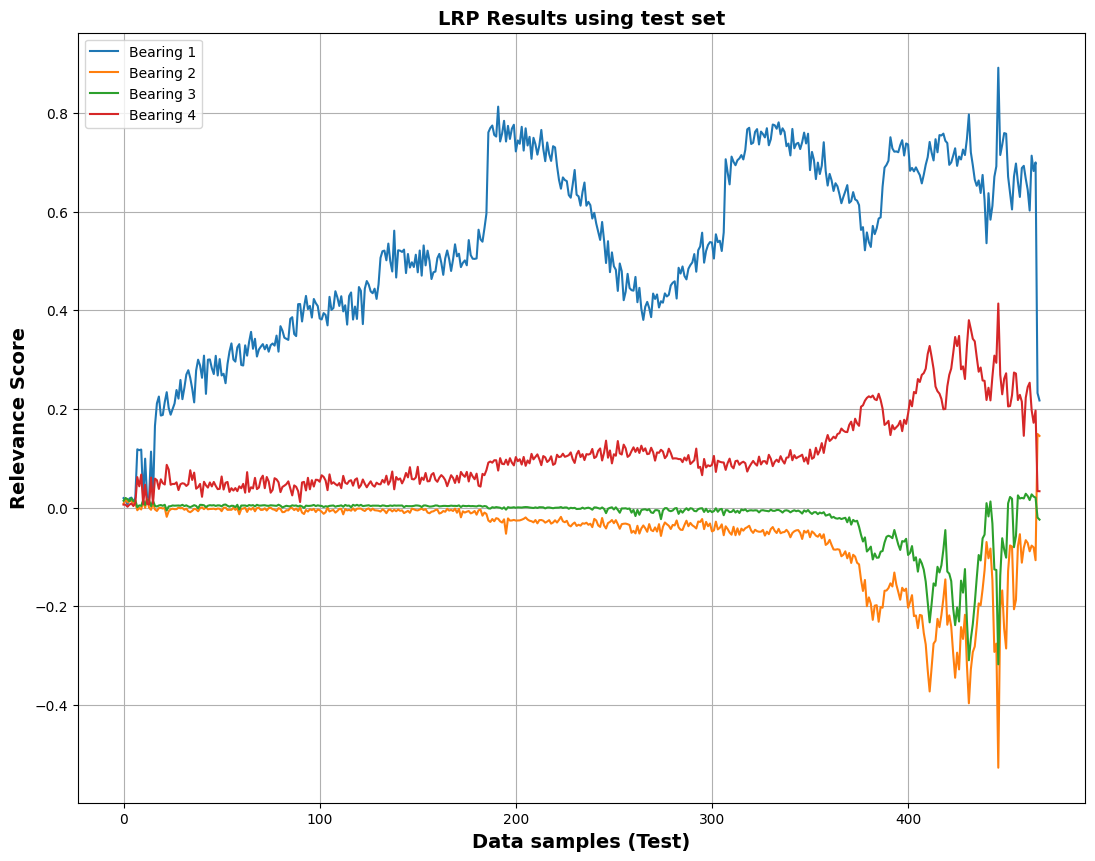

In [34]:
feature = ['Bearing 1', 'Bearing 2', 'Bearing 3', 'Bearing 4']
plt.figure(figsize=(13,10))
plt.plot(explanations)
plt.legend(labels=feature)
plt.title("LRP Results using test set", fontsize=14, fontweight='bold')
plt.xlabel("Data samples (Test)", fontsize=14, fontweight='bold')
plt.ylabel("Relevance Score", fontsize=14, fontweight='bold')
plt.grid()
plt.rcParams["font.weight"] = "bold"
plt.rcParams["axes.labelweight"] = "bold"

[ 0.32929794 -0.00048197  0.00454274  0.0300774 ]


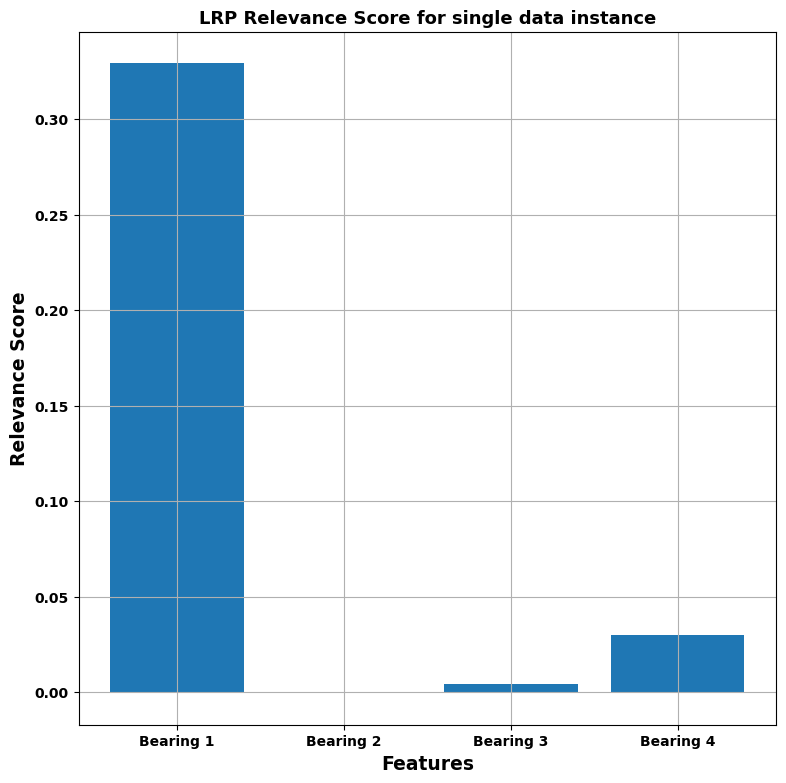

In [35]:
print(explanations[75])
features = ['Bearing 1', 'Bearing 2', 'Bearing 3', 'Bearing 4']
plt.figure(figsize=(9,9))
plt.title("LRP Relevance Score for single data instance", fontsize=13, fontweight='bold')
plt.bar(features, explanations[75])
plt.xlabel("Features", fontsize=13.5, fontweight='bold')
plt.ylabel("Relevance Score", fontsize=13.5, fontweight='bold')
plt.grid()
plt.show()

### Issues with LRP Implementation

The major issues when using LRP implementation are listed below:

### Doesn't fit for any uni-directional LSTM models

1. From the above implementation, it is pretty evident that this LRP implementation works for bi-directional LSTM models but when it is applied to any uni-directional LSTM models, it does not fit.
2. Adding to it, it doesn't fit for every bi-directional model instead. The current implementation works with only the model with single bi-directional LSTM layer and dense layer. If additional layers are added, then the dimension of weight matrix changes and it throws an assertion error.

In [ ]:
lrp_lstm_model = tf.keras.models.load_model('D:/DLR/Implementation/New Model/LRP/model/anomaly_detection_model.h5')
lrp_lstm_model.summary()
weights_uni_lstm = weight_params(lrp_lstm_model)

In [ ]:
#LRP Implementation for unidirectional LSTM
n_hidden = 4
input_dim = 4
n_classes = 4

lrp_model = LSTM_network(n_hidden, input_dim, n_classes, weights=weights_lstm)

### Wrap-up

1. LRP fits for LSTM regression models trained using time series data for anomaly detection.
2. But, the current LRP implementation is limited to bi-directional LSTM model with only a dense layer.
3. As of now, it does not fit for any other models (uni-directional LSTM, encoder-decoder based, multiple bi-directional LSTM layers).
4. Current implementation can be extended to support the above model configuration but it is time consuming as this implementation is manual. But it can be done as a future step.

### Reference

[1] https://github.com/alewarne/Layerwise-Relevance-Propagation-for-LSTMs <br>
[2] https://colah.github.io/posts/2015-08-Understanding-LSTMs/ <br>
[3] https://www.kaggle.com/vinayak123tyagi/bearing-dataset